# Your mission


You started working in a financial institution. You manager Mark is insterested in investing and trading **Bitcoin** to diversify his portfolio. So he turned to you to develop a crypto trading bot.

A **crypto trading bot** is a computer program with an underlying predictive model that automatically outputs a predicted day to day price for the next 30 days based on the history of Bitcoin market price and Blockchain variables. 

Your mission is to train an accurate predictive model with the lowest mean squared error. Mark is a very technical guy, he likes to understand all **technical details** and would like you to **compare the performances of classical models and neural-net based models**.

Your **target variable** is the Bitcoin Market price.

**Data source** : https://blockchain.info/

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats as sct
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import helper_functions as hf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestRegressor 
import itertools
import warnings
warnings.filterwarnings('ignore')

CURDIR = os.path.dirname(os.getcwd())
DATADIR = os.path.join(CURDIR,  "data")
%matplotlib inline

# Data Exploration


In this section, you are to explore the data. You are to fulfill the following tasks:
- **Univariate analysis**
    - study the Bitcoin market price time series, in terms of its trend, cycle, seasonality, and stationnarity 
    - **Tips**: you can analyse ACF, PACF plots, perform Augmented Dickey-Fuller test
- **Multivariate analysis**
    - study other blockchain variables, retrieve insights
    - study the correlation between the Bitcoin market price and other blockchain variables 
    - **Tips**: Pearson correlation

In [2]:
df_blockchain = pd.read_csv(os.path.join(DATADIR, "df_blockchain.csv"), 
                            delimiter=",")
df_blockchain=df_blockchain.dropna()

In [3]:
df_blockchain.head()

,Date,market-price,n-transactions-per-block,median-confirmation-time,hash-rate,difficulty,miners-revenue,trade-volume,blocks-size,avg-block-size,...,cost-per-transaction,n-unique-addresses,n-transactions,n-transactions-total,n-transactions-excluding-popular,output-volume,estimated-transaction-volume,estimated-transaction-volume-usd,total-bitcoins,market-cap
0,2011-09-13,6.88,45.908451,0.0,12.018816,1.777774e+06,52318.011503,0.0,592.190091,0.019009,...,7.666766,12622.0,6519.0,1497195.0,6519.0,358543.612114,58615.641320,403275.612279,7.257416e+06,5.022014e+07
1,2011-09-14,6.19,42.465753,0.0,13.263925,1.755425e+06,48306.468911,0.0,594.907367,0.018007,...,7.369408,12408.0,6200.0,1503780.0,6200.0,302619.024544,74521.484625,461287.989830,7.264662e+06,4.540930e+07
2,2011-09-15,5.92,41.500000,0.0,12.914875,1.755425e+06,60431.444952,0.0,597.554226,0.018240,...,7.333913,12988.0,6474.0,1509972.0,6474.0,299226.130646,79422.402932,470180.625359,7.272284e+06,4.322228e+07
3,2011-09-16,5.58,52.176471,0.0,10.995096,1.755425e+06,34345.021913,0.0,600.362512,0.022136,...,5.466341,12059.0,6209.0,1516381.0,6209.0,674606.861338,82696.853247,461448.441118,7.279040e+06,4.088136e+07
4,2011-09-17,5.18,40.701493,0.0,10.733308,1.755425e+06,36805.913687,0.0,602.995510,0.017116,...,6.489054,10988.0,5454.0,1522600.0,5454.0,354198.945778,68238.166521,353473.702578,7.285375e+06,3.801833e+07


In [4]:
df_blockchain.describe()

,market-price,n-transactions-per-block,median-confirmation-time,hash-rate,difficulty,miners-revenue,trade-volume,blocks-size,avg-block-size,transaction-fees,...,cost-per-transaction,n-unique-addresses,n-transactions,n-transactions-total,n-transactions-excluding-popular,output-volume,estimated-transaction-volume,estimated-transaction-volume-usd,total-bitcoins,market-cap
count,3533.000000,3533.000000,3533.000000,3.533000e+03,3.533000e+03,3.533000e+03,3.533000e+03,3533.000000,3533.000000,3533.000000,...,3533.000000,3.533000e+03,3533.000000,3.533000e+03,3533.000000,3.533000e+03,3.533000e+03,3.533000e+03,3.533000e+03,3.533000e+03
mean,5231.194424,1221.701070,9.499950,3.022172e+07,4.159642e+12,8.138193e+06,1.754324e+08,112580.065050,0.657079,69.932153,...,33.689633,3.509665e+05,181780.579111,2.133511e+08,177425.358902,1.700443e+06,2.234710e+05,7.982378e+08,1.476389e+07,9.390506e+10
std,10135.444376,807.388254,3.533051,4.758851e+07,6.570531e+12,1.179469e+07,3.644034e+08,106290.947869,0.432953,107.844011,...,39.429523,2.393643e+05,117505.507565,2.003479e+08,113370.846035,2.114934e+06,2.899783e+05,1.506415e+09,3.180824e+06,1.887818e+11
min,2.300000,30.379310,0.000000,6.639291e+00,1.090716e+06,1.402205e+04,0.000000e+00,592.190091,0.012890,2.039890,...,0.728496,7.800000e+03,4632.000000,1.497195e+06,4632.000000,1.952812e+05,3.832831e+04,2.126303e+05,7.257416e+06,1.785951e+07
25%,235.850000,377.288344,7.383333,2.582494e+04,3.129573e+09,1.005982e+06,1.933511e+06,15564.613674,0.198485,16.916598,...,7.420886,1.321740e+05,63003.000000,3.311748e+07,63003.000000,8.411100e+05,1.267008e+05,4.328857e+07,1.241237e+07,3.351263e+09
50%,669.000000,1314.970370,8.750000,1.536337e+06,2.133989e+11,2.503198e+06,8.661711e+06,77157.249908,0.739599,32.158860,...,19.942035,3.897060e+05,200174.000000,1.437247e+08,194100.000000,1.283684e+06,1.843673e+05,1.768188e+08,1.577101e+07,1.001454e+10
75%,7324.030000,1984.073529,11.320833,4.556566e+07,6.379265e+12,1.217842e+07,1.821364e+08,196555.521155,1.015420,73.246868,...,48.094731,5.354840e+05,288256.000000,3.662394e+08,281541.000000,2.042047e+06,2.655345e+05,9.205444e+08,1.743435e+07,1.296378e+11
max,63554.440000,2762.540984,47.733333,1.985140e+08,2.504649e+13,8.017224e+07,4.956850e+09,346861.353216,1.462601,1495.946477,...,300.310549,1.072862e+06,490644.000000,6.446050e+08,470650.000000,6.735430e+07,7.483620e+06,1.464262e+10,1.871804e+07,1.186579e+12


In [5]:
df_blockchain.columns.sort_values().shape

(23,)

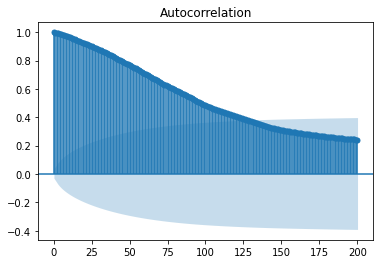

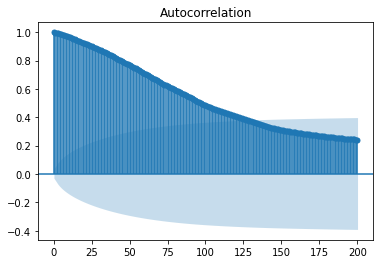

In [6]:
plot_acf(df_blockchain["market-price"],lags=200)

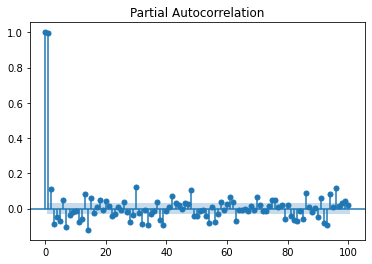

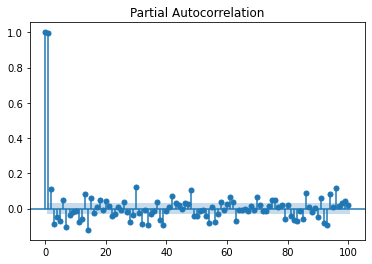

In [7]:
plot_pacf(df_blockchain["market-price"],lags=100)

Text(0.5, 0, 'days')

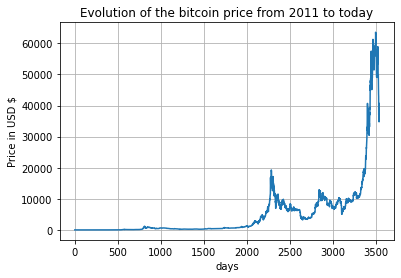

In [8]:
# Your code here for data exploration
plt.plot(df_blockchain["market-price"])
plt.ylabel("Price in USD $")
plt.grid()
plt.title("Evolution of the bitcoin price from 2011 to today")
plt.xlabel("days")

### On affiche la matrice d'autocorrelation :

<AxesSubplot:>

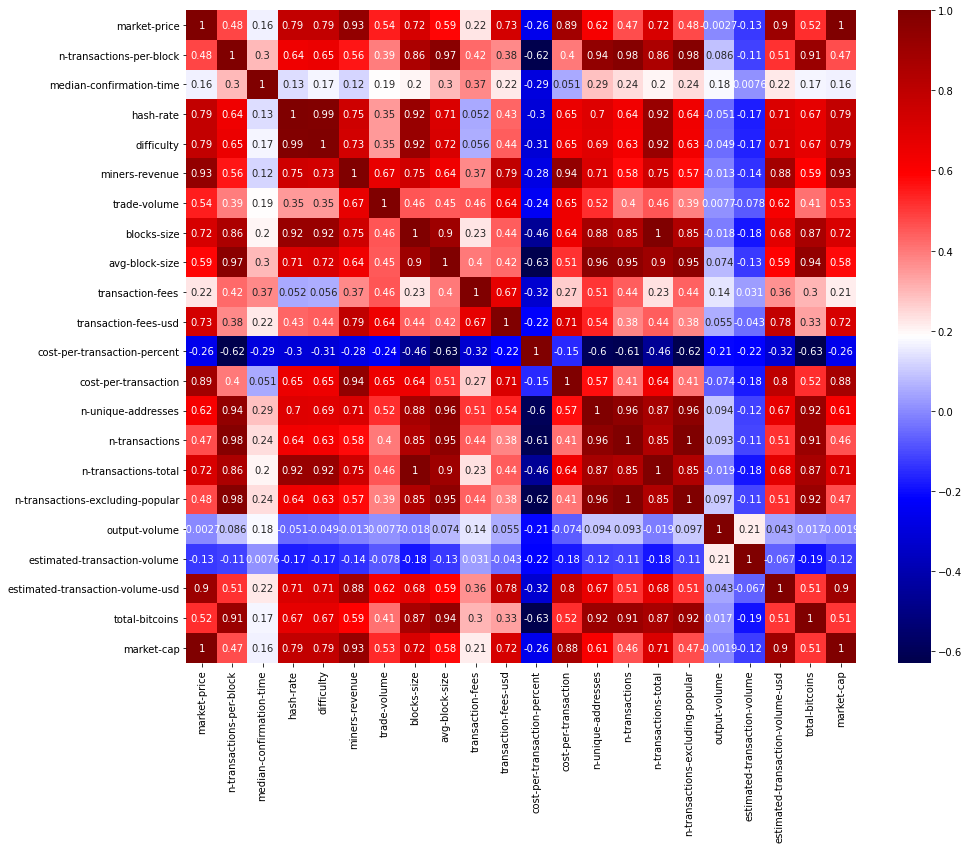

In [9]:
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(df_blockchain.corr(), cmap='seismic', annot=True, ax=ax)

In [10]:
features=df_blockchain.columns.drop("market-price").drop("Date")
features

Index(['n-transactions-per-block', 'median-confirmation-time', 'hash-rate',
       'difficulty', 'miners-revenue', 'trade-volume', 'blocks-size',
       'avg-block-size', 'transaction-fees', 'transaction-fees-usd',
       'cost-per-transaction-percent', 'cost-per-transaction',
       'n-unique-addresses', 'n-transactions', 'n-transactions-total',
       'n-transactions-excluding-popular', 'output-volume',
       'estimated-transaction-volume', 'estimated-transaction-volume-usd',
       'total-bitcoins', 'market-cap'],
      dtype='object')

# Preprocessing 

En premier lieu, on va déterminer les plus importantes variables explicatives à considérer pour prédire le market-price. On utilise ici un Random Forest Regression.

In [11]:
df_rf = df_blockchain[2000:].drop(columns = 'Date')


In [12]:
X_train, X_test = hf.data_split(df_rf)

y_train = X_train['market-price']
y_test = X_test['market-price']

X_train1= X_train.drop(columns =['market-price','market-cap'])
X_test1 = X_test.drop(columns =['market-price','market-cap'])

In [13]:
rf = RandomForestRegressor() 
## Fit the model on our training data.
rf.fit(X_train, y_train) 
## And score it on our testing data.
rf.score(X_test, y_test)

0.9709275143281105

Most important features


<AxesSubplot:>

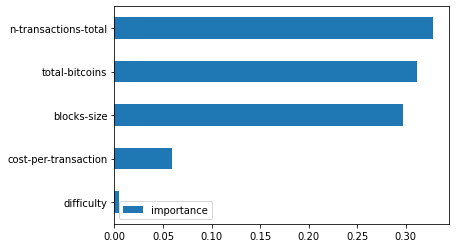

In [14]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

cols = list(feature_importances.head(n=7).transpose().columns)

X_train2 = X_train[cols].drop(columns =['market-price','market-cap'])
X_test2 = X_test[cols].drop(columns =['market-price','market-cap'])

rf2 = RandomForestRegressor() 
rf2.fit(X_train2, y_train) 
rf2.score(X_test2, y_test)
feature_importances2 = pd.DataFrame(rf2.feature_importances_,
                                   index = X_train2.columns,
                                    columns=['importance']).sort_values('importance', ascending=True)
print('Most important features')
feature_importances2.plot.barh()

On va déterminer les valeurs importantes pour notre modélisation puis nous allons normaliser et standardiser leurs distributions 

On commence par reduire la taille du dataframe, en effet les valeurs avant le jour 2000 ne semble pas avoir le même comportement ( plutôt stationnaire avant le jour 2000 et non après)

In [15]:
df_reduced=df_blockchain[2000:]
#df_reduced

Text(0.5, 1.0, 'price of bitcoin en fct du jour ')

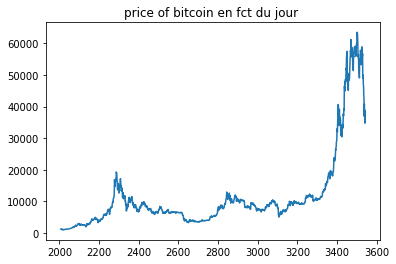

In [16]:
plt.plot(df_reduced["market-price"])
plt.title ("price of bitcoin en fct du jour ")

On va afficher les différentes distributions des features, et on va les transformer en distribution normale selon deux méthodes différentes en fonction de leur symétrie asymétrie

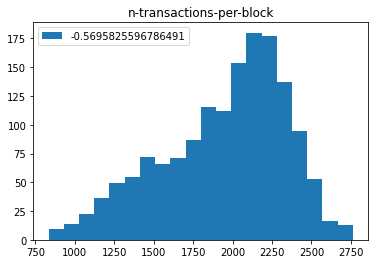

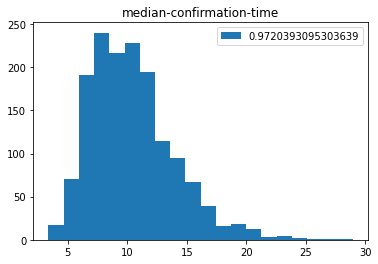

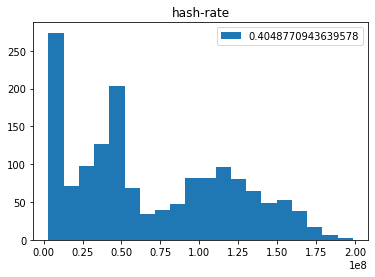

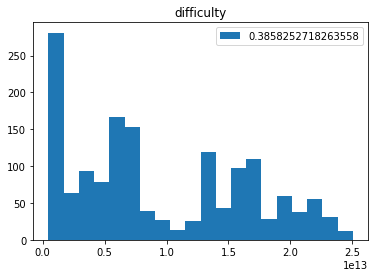

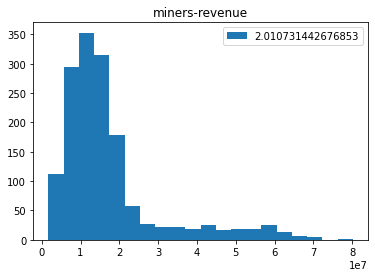

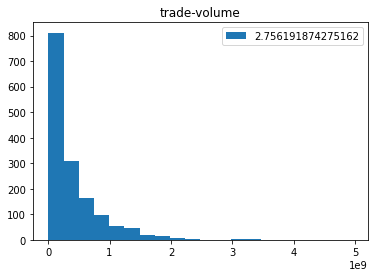

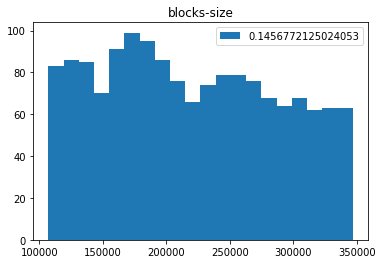

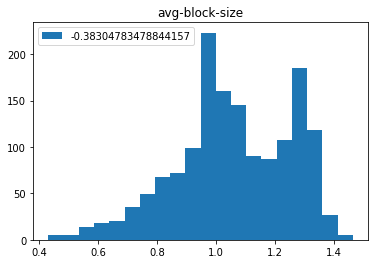

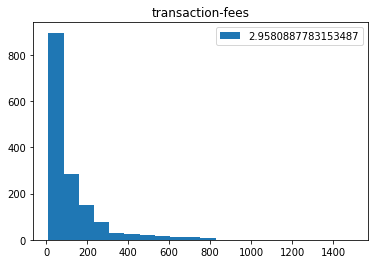

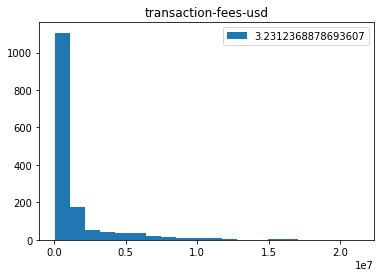

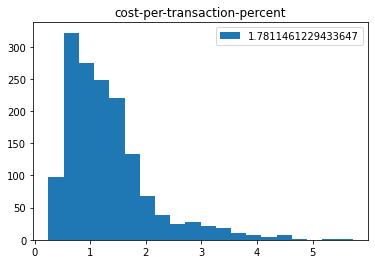

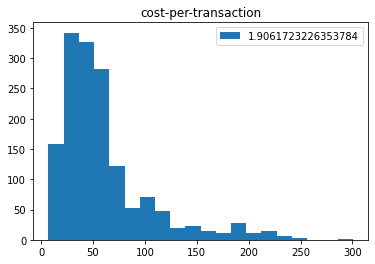

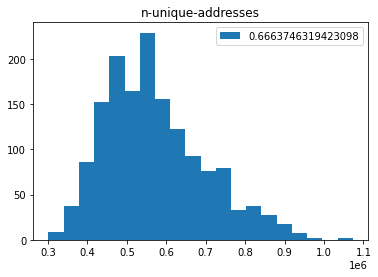

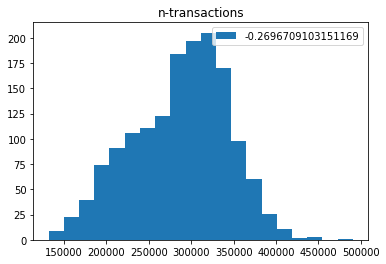

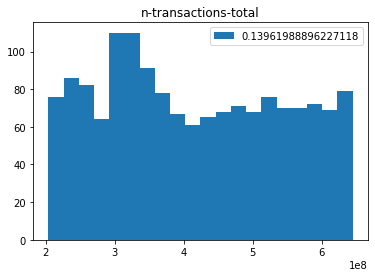

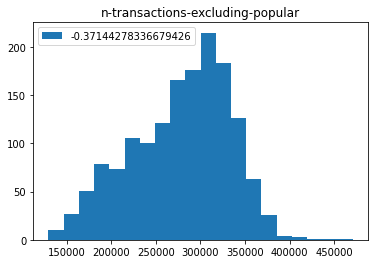

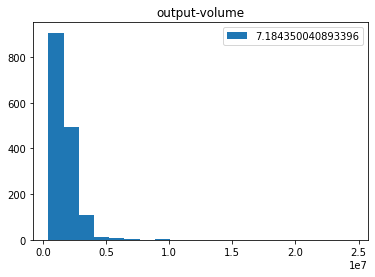

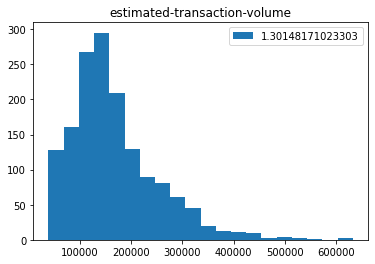

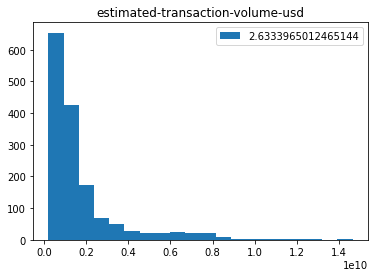

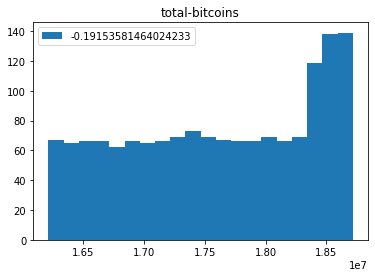

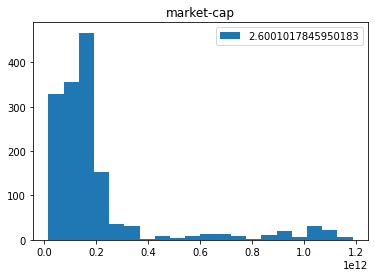

In [17]:
list_to_box=[]
list_quantile=[]
for feature in features:
    skew=sct.skew(df_reduced[feature])
    plt.figure()
    plt.hist(df_reduced[feature], bins=20,label=skew)
    plt.title (feature)
    plt.legend()
    plt.show()
    if abs(skew)>1:
        list_to_box.append(feature)
    else:
        list_quantile.append(feature)

On normalise le dataframe

In [18]:
for elt in list_to_box:
    yj = PowerTransformer(method='yeo-johnson')
    data = np.array(df_reduced[elt])
    reshaped_data = np.array(data).reshape(-1, 1)
    yj.fit(reshaped_data)
    df_reduced[elt] = yj.transform(reshaped_data)
    
rng = np.random.RandomState(304)  
for elt in list_quantile:
    qt = QuantileTransformer(output_distribution='normal',random_state=rng)
    data = np.array(df_reduced[elt])
    reshaped_data = np.array(data).reshape(-1, 1)
    qt.fit(reshaped_data)
    df_reduced[elt] = qt.transform(reshaped_data)

df_reduced

,Date,market-price,n-transactions-per-block,median-confirmation-time,hash-rate,difficulty,miners-revenue,trade-volume,blocks-size,avg-block-size,...,cost-per-transaction,n-unique-addresses,n-transactions,n-transactions-total,n-transactions-excluding-popular,output-volume,estimated-transaction-volume,estimated-transaction-volume-usd,total-bitcoins,market-cap
2007,2017-03-12,1176.59,-1.137419,1.144896,-2.244800,-3.089935,-2.462943,-2.173164,-5.199338,-0.595517,...,-2.046281,-1.286556,-1.022818,-5.199338,-0.970736,0.0,0.320346,0.0,-5.199338,0.0
2008,2017-03-13,1227.68,-0.316604,1.724021,-2.519254,-3.089935,-2.437951,-2.285202,-3.210506,-0.362863,...,-2.367557,-0.309205,-0.347853,-3.236540,-0.317723,0.0,1.097489,0.0,-3.216424,0.0
2009,2017-03-14,1240.72,-0.100337,1.456896,-2.221822,-3.089935,-2.329885,-2.293281,-3.012515,-0.578424,...,-2.436343,0.108057,0.288749,-3.016298,0.348985,0.0,1.294561,0.0,-3.008989,0.0
2010,2017-03-15,1246.72,0.075954,1.024100,-2.693594,-3.089935,-2.455681,-2.281344,-2.884449,-0.349093,...,-2.457623,-0.235579,-0.028969,-2.884684,0.039903,0.0,1.149823,0.0,-2.884767,0.0
2011,2017-03-16,1257.00,0.314477,1.104747,-2.320870,-3.089935,-2.373812,-2.461420,-2.795374,-0.320596,...,-2.524669,0.352183,0.651946,-2.796429,0.729493,0.0,2.221953,0.0,-2.793975,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3538,2021-05-21,40784.32,0.062572,1.049056,1.184344,2.696511,1.264441,1.793385,2.793846,1.066682,...,1.600898,0.958211,-0.945658,2.793174,-0.881258,0.0,0.469525,0.0,2.792488,0.0
3539,2021-05-22,37280.35,-0.225064,1.643132,1.306756,2.696511,1.222208,1.740786,2.884274,1.066035,...,1.574752,0.398514,-0.977416,2.885226,-0.920349,0.0,-0.210160,0.0,2.884469,0.0
3540,2021-05-23,37528.30,-0.755173,0.114802,1.402669,2.696511,1.117970,0.934318,3.005381,2.321264,...,1.679792,0.061598,-1.501218,3.016632,-1.378705,0.0,-0.282794,0.0,3.007992,0.0
3541,2021-05-24,34754.54,-0.358301,0.252311,1.619770,2.696511,1.295481,1.455620,3.211628,1.825335,...,1.578030,0.648850,-0.824499,3.197369,-0.761329,0.0,0.527298,0.0,3.213162,0.0


On va standardiser le dataframe et observer les nouvelles distributions 

No handles with labels found to put in legend.


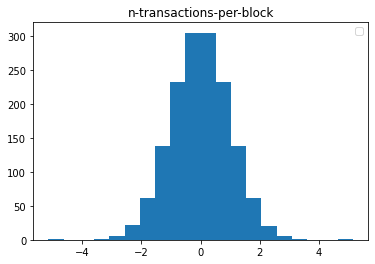

No handles with labels found to put in legend.


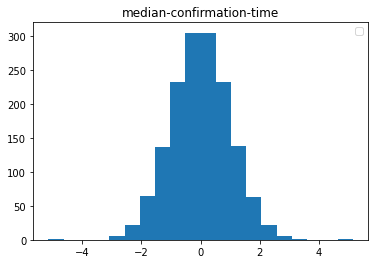

No handles with labels found to put in legend.


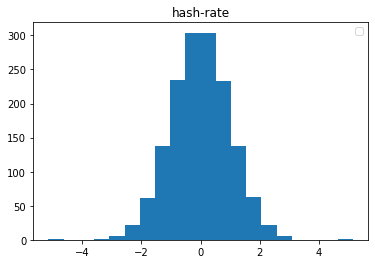

No handles with labels found to put in legend.


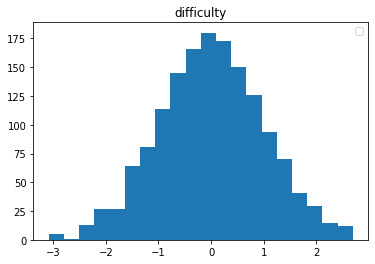

No handles with labels found to put in legend.


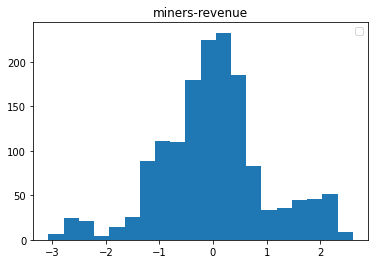

No handles with labels found to put in legend.


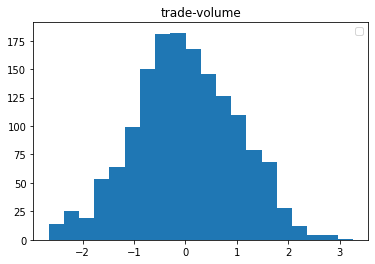

No handles with labels found to put in legend.


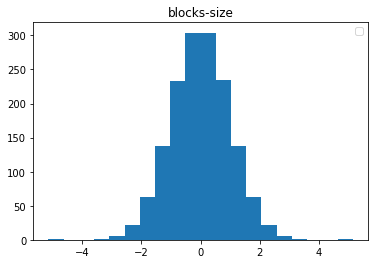

No handles with labels found to put in legend.


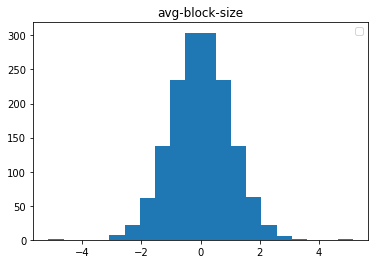

No handles with labels found to put in legend.


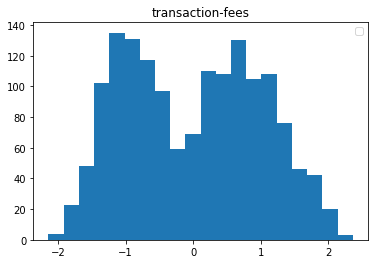

No handles with labels found to put in legend.


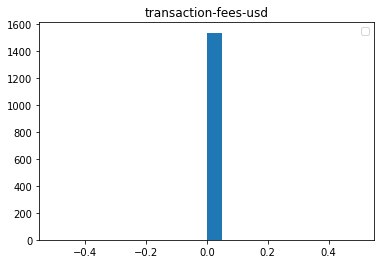

No handles with labels found to put in legend.


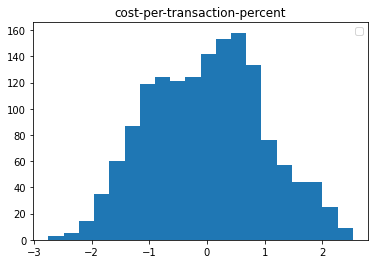

No handles with labels found to put in legend.


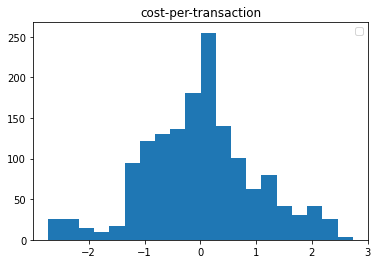

No handles with labels found to put in legend.


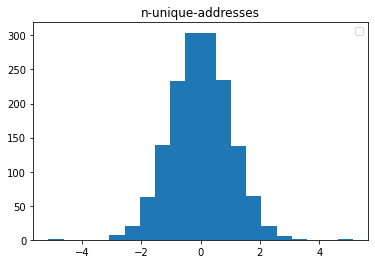

No handles with labels found to put in legend.


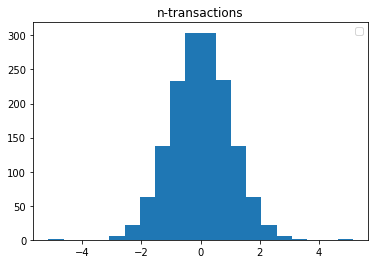

No handles with labels found to put in legend.


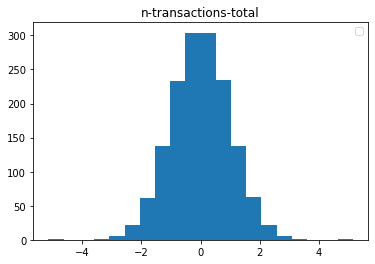

No handles with labels found to put in legend.


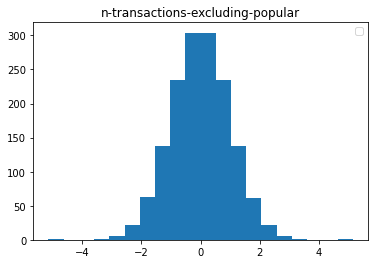

No handles with labels found to put in legend.


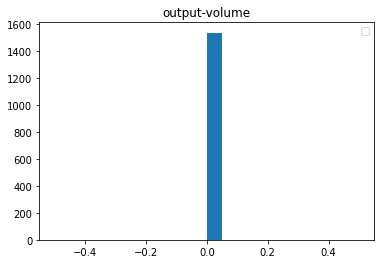

No handles with labels found to put in legend.


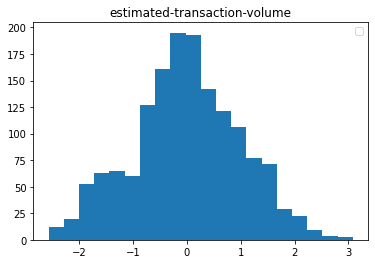

No handles with labels found to put in legend.


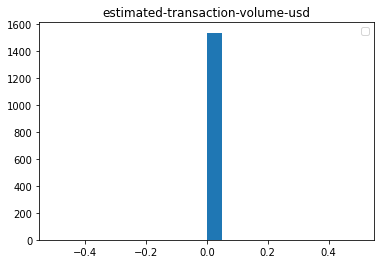

No handles with labels found to put in legend.


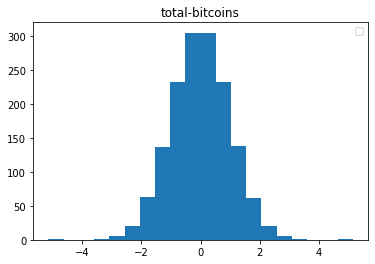

No handles with labels found to put in legend.


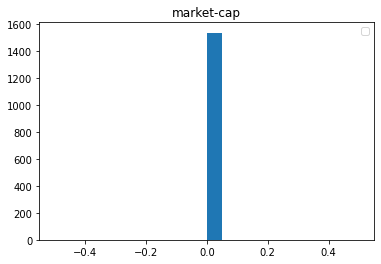

In [19]:
ss= preprocessing.StandardScaler()
df_scaled=pd.DataFrame(ss.fit_transform(df_reduced.drop(columns=["Date"]).drop(columns=["market-price"])),columns=features)
for feature in features:
    plt.figure()
    plt.hist(df_scaled[feature], bins=20)
    plt.title (feature)
    plt.legend()
    plt.show()
#df_scaled

On rajoute le price a notre dataframe (on l'avait enlevé pour les transformations)

In [20]:
df1 = pd.DataFrame({'market-price': df_reduced["market-price"]})
df1.reset_index(drop = True,inplace=True)

df_centered=pd.concat([df1, df_scaled],axis=1)
#df_centered

On veut ensuite conserver les features qui ne sont pas "trop" corrélées entre elles. En effet si elles sont très corrélés, en considérer une revient à considérer l'autre 

In [21]:
def keep_relevant_features(df,features):
    myfeatures=features
    
    correlation=df.corr()
    colonnes=df.columns.drop("Date").drop("market-price")
    for ligne in colonnes:
        for col in colonnes:
            if 0.9<abs(correlation[ligne][col])<1:
                if col in myfeatures:
                    myfeatures=myfeatures.drop(col)
            elif correlation[ligne][col]==1:
                break
    return myfeatures
            

relevant_feature=keep_relevant_features(df_reduced,df_reduced.columns)
relevant_feature

Index(['Date', 'market-price', 'n-transactions-per-block',
       'median-confirmation-time', 'trade-volume', 'avg-block-size',
       'transaction-fees', 'transaction-fees-usd',
       'cost-per-transaction-percent', 'cost-per-transaction',
       'n-unique-addresses', 'n-transactions-excluding-popular',
       'output-volume', 'estimated-transaction-volume',
       'estimated-transaction-volume-usd', 'total-bitcoins', 'market-cap'],
      dtype='object')

On conserve seulement les features importantes (dont la correlation est inférieur à 0.9 )

In [22]:
for col in df_centered.columns:
    if col not in relevant_feature: 
        df_centered=df_centered.drop(columns=[col])
df_centered

,market-price,n-transactions-per-block,median-confirmation-time,trade-volume,avg-block-size,transaction-fees,transaction-fees-usd,cost-per-transaction-percent,cost-per-transaction,n-unique-addresses,n-transactions-excluding-popular,output-volume,estimated-transaction-volume,estimated-transaction-volume-usd,total-bitcoins,market-cap
0,1176.59,-1.123538,1.130889,-2.173164,-0.588098,1.044000,0.0,0.178790,-2.046281,-1.270172,-0.958610,0.0,0.320346,0.0,-5.133940,0.0
1,1227.68,-0.312792,1.702906,-2.285202,-0.358360,1.158598,0.0,-0.619286,-2.367557,-0.305346,-0.313713,0.0,1.097489,0.0,-3.175968,0.0
2,1240.72,-0.099178,1.439059,-2.293281,-0.571219,1.272237,0.0,-0.674194,-2.436343,0.106569,0.344707,0.0,1.294561,0.0,-2.971142,0.0
3,1246.72,0.074950,1.011575,-2.281344,-0.344763,1.210404,0.0,-0.722007,-2.457623,-0.232663,0.039467,0.0,1.149823,0.0,-2.848483,0.0
4,1257.00,0.310547,1.091233,-2.461420,-0.316623,1.295073,0.0,-1.553390,-2.524669,0.347568,0.720486,0.0,2.221953,0.0,-2.758833,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,40784.32,0.061733,1.036225,1.793385,1.053264,0.734104,0.0,-1.866605,1.600898,0.945830,-0.870244,0.0,0.469525,0.0,2.757364,0.0
1529,37280.35,-0.222375,1.623010,1.740786,1.052625,0.516483,0.0,-1.221872,1.574752,0.393305,-0.908849,0.0,-0.210160,0.0,2.848187,0.0
1530,37528.30,-0.745982,0.113439,0.934318,2.292118,0.303814,0.0,-1.115660,1.679792,0.060706,-1.361508,0.0,-0.282794,0.0,2.970156,0.0
1531,34754.54,-0.353978,0.249259,1.455620,1.802406,0.465432,0.0,-1.801829,1.578030,0.640432,-0.751806,0.0,0.527298,0.0,3.172746,0.0


# Modeling 
In this section, you are to perform some classical modelings, the suggested method here is ARIMA, but you can try other models such as ARMA, ARIMAX, SARIMAX...


Nous allons nous inéresser à des modèles de type ARMA, ARIMA et ARIMAX .

## Search for the best ARMA model

We use grid search to search for the best ARMA parameters that gives the lowest error. This follows the Box-Jenkins methology.

In [23]:
X_train, X_test = hf.data_split(df_centered)


In [24]:
best_cfg, best_score = hf.arma_grid_search(X_train["market-price"], 
                                            X_test["market-price"],
                                            np.arange(1,5), np.arange(5))

Best ARMA(2, 0) MSE=2865.798


La meilleure erreur est obtenue pour un ARMA(3,0)

## Search for the best ARIMA model
We use grid search to search for the best ARIMA parameters that gives the lowest error. This follows the Box-Jenkins methology.

On définit les valeurs de Train et de Test

In [25]:
X_train, X_test = hf.data_split(df_centered)


In [26]:
best_cfg, best_score = hf.arima_grid_search(X_train["market-price"], 
                                            X_test["market-price"],
                                            np.arange(1,3), np.arange(3), np.arange(3))

ARIMA(1,0,0) RMSE=2933.019
ARIMA(1,1,0) RMSE=2906.488
ARIMA(1,1,1) RMSE=2899.329
ARIMA(1,1,2) RMSE=2862.710
ARIMA(1,2,0) RMSE=3405.106
ARIMA(1,2,1) RMSE=2949.703
ARIMA(1,2,2) RMSE=2944.974
ARIMA(2,0,0) RMSE=2865.798
ARIMA(2,1,0) RMSE=2873.621
ARIMA(2,1,1) RMSE=2865.338
ARIMA(2,1,2) RMSE=2881.300
ARIMA(2,2,0) RMSE=3248.309
ARIMA(2,2,1) RMSE=2908.411
ARIMA(2,2,2) RMSE=2965.729
Best ARIMA(1, 1, 2) MSE=2862.710


La meilleure erreur est obtenue pour un ARIMA(1,1,2)

## Visualization
To have a better view on the difference between true and predict values, we visualize them by plotting both the signals.

In [27]:
parameters = (1,1,2)
errors, predictions = hf.evaluate_arima_model(X_train["market-price"], 
                                              X_test["market-price"], parameters)

In [28]:
# prepare the dataset for plotting
predict_date = df_blockchain.iloc[-30::]["Date"]
df_predict = pd.DataFrame(zip(predict_date,
                              predictions, X_test["market-price"].values),
                          columns=["date", "predict", "true"])

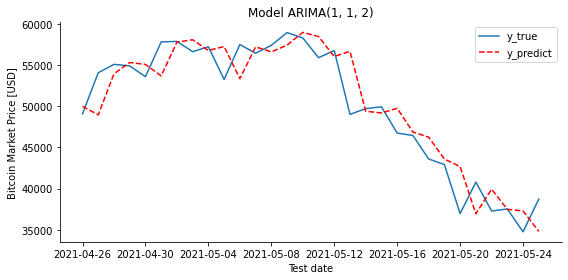

In [29]:
fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x="date", y="true", data=df_predict, 
             ax=ax, label="y_true", markers=True )
plot_ = sns.lineplot(x="date",
             y="predict",
             data=df_predict,
             color="red",ax=ax, label="y_predict")
plot_.lines[1].set_linestyle("--")
new_ticks = plot_.get_xticklabels()
freq = 4
ax.set_xticks(np.arange(0, len(new_ticks), freq))
labels = predict_date[::freq]
ax.set_xticklabels(labels)
ax.set_ylabel("Bitcoin Market Price [USD]")
ax.set_xlabel("Test date")
ax.set_title(f"Model ARIMA{parameters}")
sns.despine()
plt.legend()
plt.tight_layout()

## Search for the best ARIMAX model
ARIMAX est un modèle qui en plus des paramètres classiques (p,d,q) du modèle ARIMA prend un set de paramètres exogènes X pour modéliser la série temporelle

On va d'abord transformer les fonctions evaluate_arima et grid_search_arima pour pouvoir prendre en compte les paramètres exogènes

In [30]:
def evaluate_arimax_model(X_train, X_test, arima_order, exogenous_var_train, exogenous_var_test):
 
   
    mycolonne=exogenous_var_train.columns
    history = [x for x in X_train]
    exog=np.array([[x for x in exogenous_var_train[elt]] for elt in exogenous_var_train.columns]).T.tolist()
    exog_test=np.array([[x for x in exogenous_var_test[elt]] for elt in exogenous_var_test.columns]).T.tolist()
    print(np.array(exog))
    # make predictions
    predictions = list()

    for t in range(len(X_test)):
        model = ARIMA(endog=history, order=arima_order, exog=exog) ##détermination du ARIMA avec variables exogenes
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast(steps=1,exog=[exog_test[t]]) ## fit avec variables exogènes
        predictions.append(yhat[0][0])       # ajout de la valeur prédite
        history.append(X_test.values[t])    # mise a jour de l'history de ce qui s'est passé 
        exog.append(exog_test[t])          # mise a jour des valeurs exogenes
    # calculate out of sample error
    error = hf.rmse(X_test, predictions)

    return error, predictions

def arimax_grid_search(X_train, X_test, p_values, d_values, q_values, exogenous_var_train, exogenous_var_test):


    best_score, best_cfg = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse, _ = evaluate_arimax_model(
                        X_train, X_test, order, exogenous_var_train, exogenous_var_test)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print("ARIMAX(%d,%d,%d) RMSE=%.3f Exogenous =" %
                          (p, d, q, rmse))

                except:
                    continue

    print("Best ARIMAX%s MSE=%.3f" % (best_cfg, best_score))

    return best_cfg, best_score


Cependant, la libraire ARIMA est maintenant déconseillée et il est conseillé d'utiliser plutôt SARIMAX. Nous avons donc réimplémenter les fonctions avec la méthode SARIMAX qui est effectivement un peu plus rapide (on ne considère pas de saisonnalité pour correspondre à un ARIMAX)

In [31]:
def evaluate_sarimax_model(X_train, X_test, arima_order, exogenous_var_train, exogenous_var_test):
 
    mycolonne=exogenous_var_train.columns
    history = [x for x in X_train]
    exog=np.array([[x for x in exogenous_var_train[elt]] for elt in exogenous_var_train.columns]).T.tolist()
    exog_test=np.array([[x for x in exogenous_var_test[elt]] for elt in exogenous_var_test.columns]).T.tolist()
    # make predictions
    predictions = list()

    for t in range(len(X_test)):
        model = SARIMAX(endog=history, order=arima_order, exog=exog,enforce_stationarity=False)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast(steps=1,exog=[exog_test[t]])
        predictions.append(yhat[0])
        history.append(X_test.values[t])
        exog.append(exog_test[t])
 
    error = hf.rmse(X_test, predictions)

    return error, predictions

def sarimax_grid_search(X_train, X_test, p_values, d_values, q_values, exogenous_var_train, exogenous_var_test):


    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse, _ = evaluate_sarimax_model(
                        X_train, X_test, order, exogenous_var_train, exogenous_var_test)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print("ARIMAX(%d,%d,%d) RMSE=%.3f Exogenous =" %
                          (p, d, q, rmse))

                except:
                    continue

    print("Best ARIMAX%s MSE=%.3f" % (best_cfg, best_score))

    return best_cfg, best_score

In [32]:
def combinaison_exo(df,ne):  # cette fonction permet de déterminer les combinaisons de paramètres à effectuer avec ne le nombre de variables exogènes 
    L=[]
    colonnes=list(df.columns)
    return list(itertools.combinations(colonnes,ne))


On a déterminé le meilleur set de paramètre comme le suivant : 


In [33]:
L1=['n-transactions-per-block', 'median-confirmation-time', 'trade-volume', 'cost-per-transaction', 'n-unique-addresses','n-transactions-excluding-popular','transaction-fees','avg-block-size','transaction-fees-usd']
exo_train=X_train[L1]  
exo_test=X_test[L1]
parameters = (2,1,1)
errors_arimax, predictions_arimax = evaluate_sarimax_model(X_train["market-price"], 
                                            X_test["market-price"],
                                            parameters,exogenous_var_train=exo_train, exogenous_var_test=exo_test)
errors_arimax

2737.676907878936

In [34]:
# prepare the dataset for plotting
predict_date = df_blockchain.iloc[-30::]["Date"]
df_predict_arimax = pd.DataFrame(zip(predict_date,predictions,
                              predictions_arimax, X_test["market-price"].values),
                          columns=["date", "predict_arima","predict_arimax", "true"])

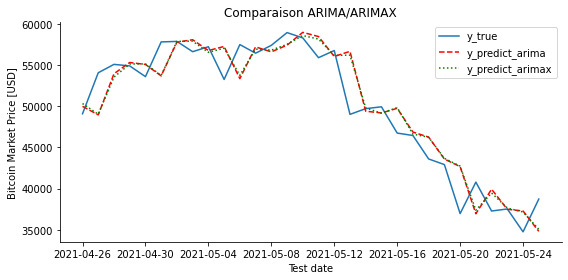

In [35]:
fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x="date", y="true", data=df_predict_arimax, 
             ax=ax, label="y_true", markers=True )
plot_ = sns.lineplot(x="date",
             y="predict_arima",
             data=df_predict_arimax,
             color="red",ax=ax, label="y_predict_arima")
plotx = sns.lineplot(x="date",
             y="predict_arimax",
             data=df_predict_arimax,
             color="green",ax=ax, label="y_predict_arimax")
plotx.lines[2].set_linestyle(":")
plot_.lines[1].set_linestyle("--")
new_ticks = plot_.get_xticklabels()
freq = 4
ax.set_xticks(np.arange(0, len(new_ticks), freq))
labels = predict_date[::freq]
ax.set_xticklabels(labels)
ax.set_ylabel("Bitcoin Market Price [USD]")
ax.set_xlabel("Test date")
ax.set_title("Comparaison ARIMA/ARIMAX")
sns.despine()
plt.legend()
plt.tight_layout()